# Group Data Analysis PCA 7th Trial - vector length
* Version: '0.0.4'
* Date: 2021-05-03
* Author: Jea Kwon
* Description: PCA analysis with Vector length

In [1]:
from avatarpy import Avatar
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cufflinks as cf
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
cf.go_offline(connected=True)

In [2]:
root = r"C:\Users\Jay\Desktop\avatar_young_adult\data\best1_20210503"

In [3]:
avatars = dict(
    wt=dict(
        young=[],
        adult=[],
    ),
    ko=dict(
        young=[],
        adult=[],
    )
)
for path, subdirs, files in os.walk(root):
    for name in files:
        if name.lower().endswith('.csv'):
            csv_path = os.path.join(path, name)
            age = os.path.basename(os.path.dirname(path))
            genotype = os.path.basename(os.path.dirname(os.path.dirname(path)))
            
            avatars[genotype][age].append(Avatar(csv_path=csv_path, ID=name))

## Create walking event data
### Definition of walking
- Moved more than 5 cm in 1 second(20=Frame)
- More details take a look Group_Data_Analysis_PCA_1st_Trial

## Event Search function

In [4]:
def get_event_indices(boo, event_length):
    """Returns list of event indices.
    
    ex) [(start 1, end 1), (start 2, end 2), (start 3, end 3), ..., (start N, end N)]
    """
    indices = np.arange(len(boo))
    condition = np.nonzero(boo[1:] != boo[:-1])[0] + 1
    split_indices = np.split(indices, condition)
    true_indices = split_indices[0::2] if boo[0] else split_indices[1::2]
    event_indice_pair = [(idx[0]-event_length+1, idx[0]+1) for idx in true_indices]
    return event_indice_pair

## Validation of event search

- Take a look Group_Data_Analysis_PCA_2nd_Trial

## Collecting Event Angles data

In [6]:
ava = avatars['wt']['young'][0]
ava.vector_length

,head,fbody,hbody,tail,rarm,larm,rleg,lleg,nose2anus,lhand2nose,rhand2nose
0.00,9.410245,3.574401,3.519694,5.101311,5.728499,3.362272,6.704103,3.200380,9.996315,7.536721,6.597018
0.05,7.387418,3.558033,3.458351,5.188232,5.754445,3.408140,6.709485,3.204632,8.760924,5.820690,3.898378
0.10,6.400967,3.543443,3.397531,5.275158,5.780534,3.454296,6.715030,3.209005,7.931305,5.293270,2.125585
0.15,6.723319,3.527309,3.372314,5.285720,5.706205,3.356663,6.718106,3.201866,7.749557,5.447893,2.424113
0.20,7.050702,3.506418,3.347314,5.296472,5.643160,3.267415,6.721099,3.194854,7.676387,5.609470,2.743949
...,...,...,...,...,...,...,...,...,...,...,...
600.60,1.114350,2.367464,2.449871,5.666090,2.179295,1.647544,3.026077,2.970035,5.635336,3.427267,3.915971
600.65,1.079722,2.380271,2.451047,5.665732,2.503809,1.628503,3.026702,2.970741,5.643194,3.379875,4.030234
600.70,1.056214,2.372245,2.467017,5.670413,2.528012,1.634976,3.027679,2.965855,5.656110,3.403553,4.082573
600.75,1.079493,2.346944,2.482139,5.675011,2.524858,1.641376,3.028698,2.961087,5.669208,3.427280,4.095115


- Take a look Group_Data_Analysis_PCA_2nd_Trial

In [15]:
wt_young_event_data = []
for avatar in avatars['wt']['young']:
    boo = (avatar.distance['anus'].rolling(20).sum()>5).values # boolean array
    event_indices = get_event_indices(boo, 20)
    for i, idx in enumerate(event_indices):
        x = avatar.vector_length.loc[avatar.index[idx[0]:idx[1]]]
        if x.shape[0]!=20:
            continue
        wt_young_event_data.append(x.values.flatten())
wt_young_event_data = np.stack(wt_young_event_data)

In [16]:
wt_adult_event_data = []
for avatar in avatars['wt']['adult']:
    boo = (avatar.distance['anus'].rolling(20).sum()>5).values # boolean array
    event_indices = get_event_indices(boo, 20)
    event_data = []
    for i, idx in enumerate(event_indices):
        x = avatar.vector_length.loc[avatar.index[idx[0]:idx[1]]]
        if x.shape[0]!=20:
            continue
        wt_adult_event_data.append(x.values.flatten())
wt_adult_event_data = np.stack(wt_adult_event_data)

total 1857 events acquired from 5 wt young mice with 5 session.  
total 2248 events acquired from 5 wt adult mice with 5 session.

In [17]:
X = np.concatenate([wt_young_event_data, wt_adult_event_data])
X_ = StandardScaler().fit_transform(X)

In [18]:
X_[np.isnan(X_)] = 0

In [19]:
pca = PCA(n_components=2)
pc = pca.fit_transform(X_)

In [20]:
y = np.concatenate([np.zeros(wt_young_event_data.shape[0]), np.ones(wt_adult_event_data.shape[0])])

In [21]:
pc_y = np.c_[pc,y]
df = pd.DataFrame(pc_y,columns=['PC1','PC2','genotype'])

(-30.0, 30.0)

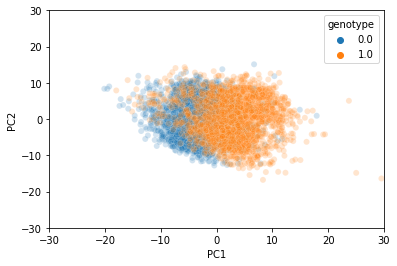

In [25]:
sns.scatterplot(data=df,x='PC1',y='PC2',hue='genotype', alpha=0.2)
plt.xlim(-30, 30)
plt.ylim(-30, 30)